In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from typing import Any
import shap
import json

from scripts.data_processing.market_data_processing import prepare_market_data_for_model
from model_training.price_model_validation import *

In [2]:
base_path = '../data/market_data/'

In [3]:
X, y = prepare_market_data_for_model("btc_merged.csv", base_path, horizon=4*12)

In [4]:
np.random.seed(123)

### initial modelling

In [25]:
def train_and_save_scores(X: pd.DataFrame, y: pd.Series, n_splits: int = 5) -> dict[str, Any]:
    split = TimeSeriesSplit(n_splits=n_splits)
    scores = {"mse": [], "mae": [], "da": [], "sr": [], "r_squared": [], "corr": []}
    i = 0
    for train_index, test_index in split.split(X, y):
        i += 1
        model = XGBRegressor()
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores["mse"].append(mean_squared_error(y_test, y_pred))
        scores["mae"].append(mean_absolute_error(y_test, y_pred))
        scores["da"].append(directional_accuracy(y_test, y_pred))
        scores["sr"].append(sharpe_ratio(y_test, y_pred))
        scores["r_squared"].append(r2_score(y_test, y_pred))
        scores['corr'].append(calculate_correlation(y_test, y_pred))

    model = XGBRegressor()
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    fig = shap.summary_plot(shap_values, X, show=False)
    plt.tight_layout()
    plt.savefig("shap_values.png")
    plt.close()

    shap.dependence_plot("volatility_4h", shap_values.values, X)

    xgb_importances = pd.Series(model.feature_importances_, index=X.columns.tolist()).sort_values(ascending=False)

    scores['xgb_importances'] = xgb_importances.to_dict()
    return scores

In [6]:
def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()
    else:
        return obj

def save_dict_to_json(data_dict, filename):
  data = make_json_serializable(data_dict)
  with open(f"{filename}.json", "w") as f:
    json.dump(data, f, indent=4)

/var/folders/17/g4ry6q7j58sflk856bs512vm0000gn/T/ipykernel_82846/496534644.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  fig = shap.summary_plot(shap_values, X, show=False)


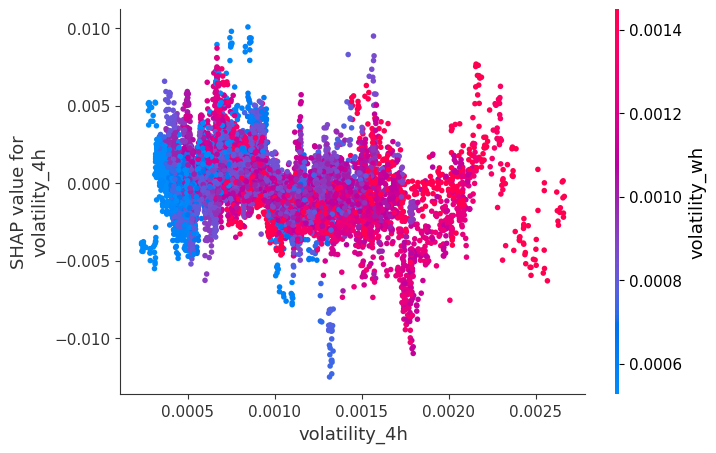

In [26]:
scores = train_and_save_scores(X, y, n_splits=5)

In [17]:
print(f"mean mse: {np.mean(scores['mse'])}")
print(f"mean mae: {np.mean(scores['mae'])}")
print(f"mean da: {np.mean(scores['da'])}")
print(f"mean sr: {np.mean(scores['sr'])}")
print(f"mean r_squared: {np.mean(scores['r_squared'])}")
print(f"mean corr: {np.mean(scores['corr'])}")

mean mse: 7.10776274995476e-05
mean mae: 0.00631039856788067
mean da: 0.5234789100410602
mean sr: 0.03142532235084617
mean r_squared: -0.4038802745076383
mean corr: 0.049404568663559675


In [9]:
0.008426156475609358 ** 2

7.100011295145352e-05

In [24]:
save_dict_to_json(scores, "xgb_feature_importance.ipynb")